# 📊 Reviewer Consensus Analysis

This notebook helps you analyze the reviewer agreement from your consensus CSV output.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import ast

# Load the consensus CSV file
df = pd.read_csv("review_consensus.csv")
df.sample(20)

,Index,Total Reviewers,All Correct Count,Consensus Count,Agreed Criteria,Error Summary
0,1,5,0,1,['identifier_database_errors'],"{'identifier_database_errors': 1, 'interaction..."
1,2,5,4,4,['all_correct'],{'correct_but_could_be_more_precise': 1}
2,3,5,4,4,['all_correct'],"{'correct_but_could_be_more_precise': 1, 'othe..."
3,4,5,4,4,['all_correct'],"{'correct_but_could_be_more_precise': 1, 'othe..."
4,5,5,4,3,['all_correct'],"{'identifier_database_errors': 1, 'other_error..."
5,6,5,4,4,['all_correct'],{'correct_but_could_be_more_precise': 1}
6,7,5,5,4,['all_correct'],{'correct_but_could_be_more_precise': 1}
7,8,5,5,4,['all_correct'],{'correct_but_could_be_more_precise': 1}
8,9,5,5,4,['all_correct'],{'correct_but_could_be_more_precise': 1}
9,10,5,5,4,['all_correct'],{'correct_but_could_be_more_precise': 1}


In [26]:
# Count statements where 4 or 5 reviewers agreed on the same error type
error_agreement = Counter()

for _, row in df.iterrows():
    error_summary = ast.literal_eval(row["Error Summary"])
    for error_type, count in error_summary.items():
        if count >= 3:
            error_agreement[error_type] += 1

# Display results
for error_type, num_statements in error_agreement.items():
    print(f"{num_statements} statements where 4 or more reviewers agreed on '{error_type}'")

1 statements where 4 or more reviewers agreed on 'correct_but_could_be_more_precise'
1 statements where 4 or more reviewers agreed on 'other_errors'


## Distribution of Reviewer Agreement

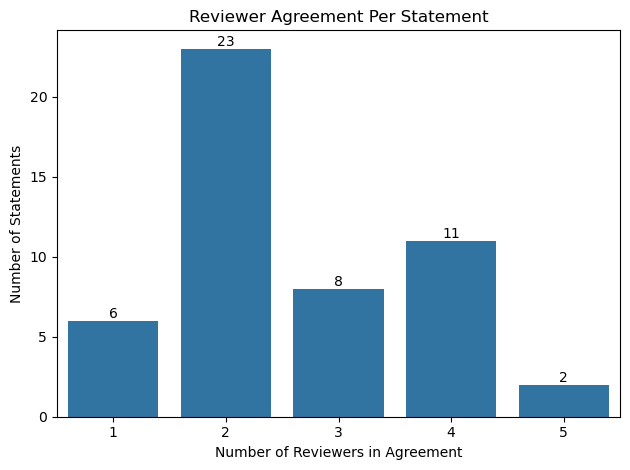

In [7]:
ax = sns.countplot(x="Consensus Count", data=df)
ax.bar_label(ax.containers[0])
plt.title("Reviewer Agreement Per Statement")
plt.xlabel("Number of Reviewers in Agreement")
plt.ylabel("Number of Statements")
plt.tight_layout()
plt.show()


## ✅ Distribution of 'All Correct' Scores

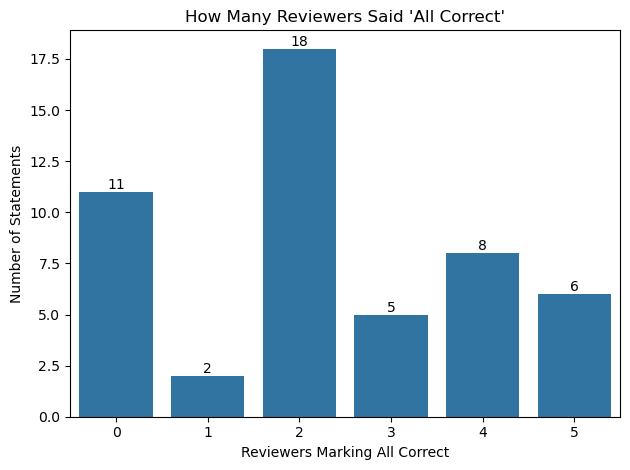

In [8]:
ax = sns.countplot(x="All Correct Count", data=df)
ax.bar_label(ax.containers[0])
plt.title("How Many Reviewers Said 'All Correct'")
plt.xlabel("Reviewers Marking All Correct")
plt.ylabel("Number of Statements")
plt.tight_layout()
plt.show()


## ❌ Most Common Error Types

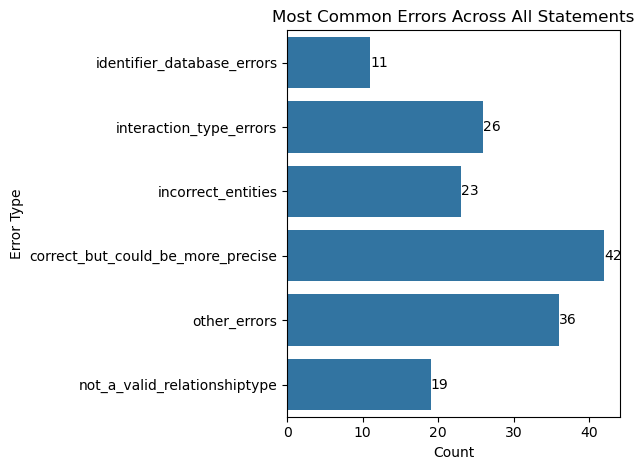

In [9]:
# Aggregate all errors across statements
error_counts = Counter()
for val in df["Error Summary"]:
    err_dict = ast.literal_eval(val)
    error_counts.update(err_dict)

# Plot
err_df = pd.DataFrame(error_counts.items(), columns=["Error Type", "Count"])
ax = sns.barplot(data=err_df, x="Count", y="Error Type")
ax.bar_label(ax.containers[0])
plt.title("Most Common Errors Across All Statements")
plt.tight_layout()
plt.show()

## Tagging Easy vs Difficult Statements

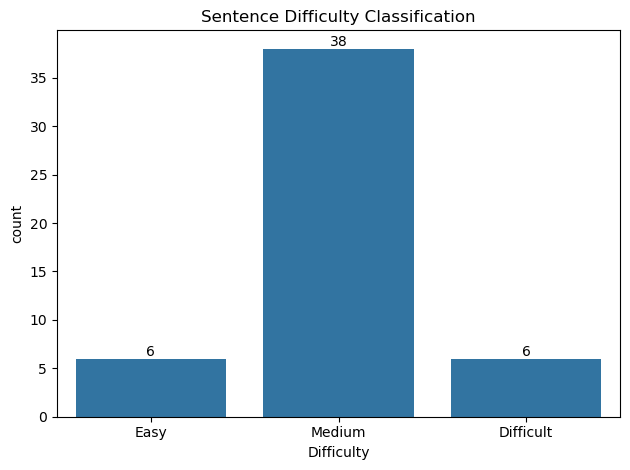

In [10]:
def classify_difficulty(row):
    if row["All Correct Count"] == 5:
        return "Easy"
    elif row["Consensus Count"] < 2:
        return "Difficult"
    else:
        return "Medium"

df["Difficulty"] = df.apply(classify_difficulty, axis=1)
ax = sns.countplot(data=df, x="Difficulty", order=["Easy", "Medium", "Difficult"])
ax.bar_label(ax.containers[0])
plt.title("Sentence Difficulty Classification")
plt.tight_layout()
plt.show()

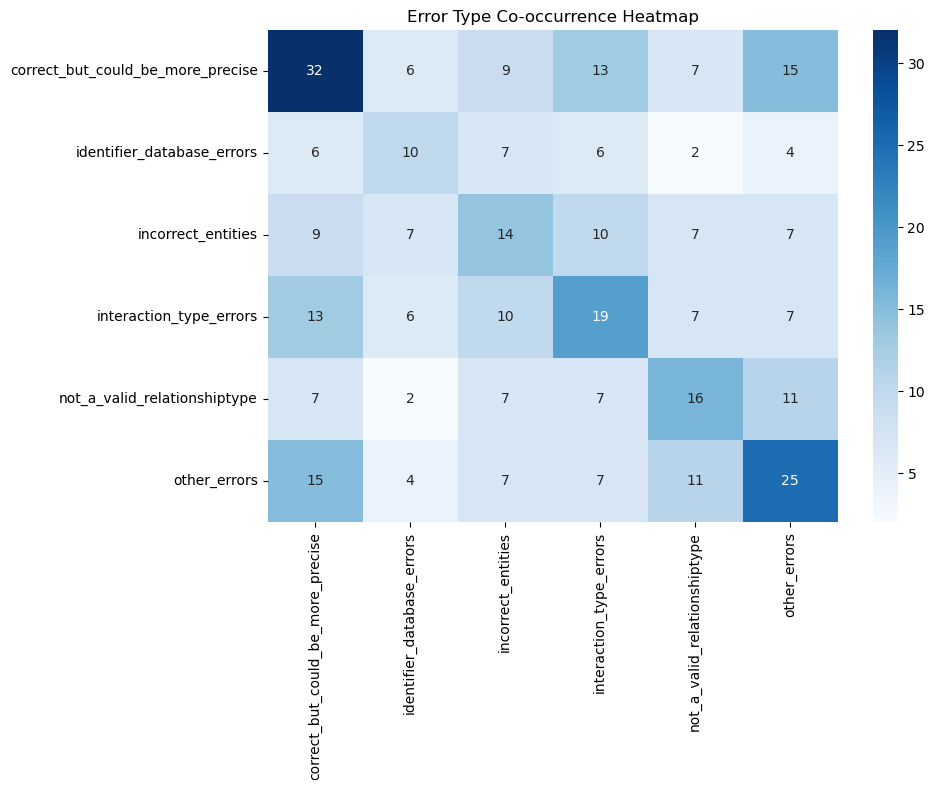

In [15]:
import numpy as np
from collections import defaultdict

# Calculate co-occurrences of error types
error_keys = set()
co_matrix = defaultdict(lambda: defaultdict(int))

for val in df["Error Summary"]:
    err_dict = ast.literal_eval(val)
    keys = list(err_dict.keys())
    for i in range(len(keys)):
        for j in range(len(keys)):
            co_matrix[keys[i]][keys[j]] += 1
            error_keys.add(keys[i])
            error_keys.add(keys[j])

# Convert to matrix
sorted_keys = sorted(error_keys)
matrix = np.zeros((len(sorted_keys), len(sorted_keys)), dtype=int)

for i, key1 in enumerate(sorted_keys):
    for j, key2 in enumerate(sorted_keys):
        matrix[i, j] = co_matrix[key1][key2]

# Create DataFrame for seaborn
co_df = pd.DataFrame(matrix, index=sorted_keys, columns=sorted_keys)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_df, annot=True, fmt="d", cmap="Blues")
plt.title("Error Type Co-occurrence Heatmap")
plt.tight_layout()
plt.show()


In [18]:
total_reviews = len(df) * 5
strict_correct = df["All Correct Count"].sum()
relaxed_correct = 0

# Count relaxed correct scores
for val in df["Error Summary"]:
    score = ast.literal_eval(val)
    count_precise = score.get("correct_but_could_be_more_precise", 0)
    relaxed_correct += count_precise

# Total relaxed = all_correct + correct_but_could_be_more_precise
total_relaxed_correct = strict_correct + relaxed_correct
relaxed_accuracy = total_relaxed_correct / total_reviews

print(f"Strict Accuracy (All Correct only): {strict_correct / total_reviews:.2%}")
print(f"Relaxed Accuracy (Including 'correct_but_could_be_more_precise'): {relaxed_accuracy:.2%}")


Strict Accuracy (All Correct only): 46.00%
Relaxed Accuracy (Including 'correct_but_could_be_more_precise'): 62.80%


In [19]:
# Mean Consensus Score
mean_consensus = df["Consensus Count"].mean()

print(f"Average Reviewer Agreement (Consensus Score): {mean_consensus:.2f} out of 5")

Average Reviewer Agreement (Consensus Score): 2.60 out of 5


In [20]:
fully_precise_count = 0

for _, row in df.iterrows():
    score_dict = ast.literal_eval(row["Error Summary"])
    # If this is the only error key and it appears 5 times
    if score_dict == {"correct_but_could_be_more_precise": 5}:
        fully_precise_count += 1

print(f"Statements where all 5 said 'correct_but_could_be_more_precise': {fully_precise_count}")


Statements where all 5 said 'correct_but_could_be_more_precise': 0


In [24]:
strong_agreement_count = 0
total_statements = len(df)

for _, row in df.iterrows():
    all_correct = row["All Correct Count"]
    summary = ast.literal_eval(row["Error Summary"])
    precise = summary.get("correct_but_could_be_more_precise", 0)
    total_agreed = all_correct + precise

    if total_agreed >= 4:
        strong_agreement_count += 1

percentage = (strong_agreement_count / total_statements) * 100

print(f"Statements where 4 or more reviewers agreed it was correct (all_correct + precise): {strong_agreement_count}")
print(f"Percentage of total statements: {percentage:.2f}%")


Statements where 4 or more reviewers agreed it was correct (all_correct + precise): 20
Percentage of total statements: 40.00%
